### Sparse Keypoint Matching on 3d point clouds extracted from inspiration and expiration of lungs 

In [2]:
# run imports
#key points registration

import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import nibabel as nib
import math
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load data

data = torch.load('fvmbv_sparse_keypoints.pth')
kpts_fixed = data['kpts_fixed'] #keypoints_fixed along x,y,z directions i.e 3 vectors
kpts_moving = data['kpts_moving']#keypoints_moving along x,y,z
gt_displacements = data['gt_displacements']
temp = torch.rand(2,3)
temp2 = temp
diff = temp.unsqueeze(0)-temp2.unsqueeze(1)
sum = torch.sum(temp,1)
emp = torch.empty(7)
print(emp.shape)
print(temp2)
print(diff.shape)
#print(kpts_fixed.transpose(1,0).shape)
#print(kpts_moving.shape)
#print(kpts_fixed[0:4,:-1])




torch.Size([7])
tensor([[0.7276, 0.1883, 0.5650],
        [0.8439, 0.7577, 0.0956]])
torch.Size([2, 2, 3])


#### kNN graph for fixed 3D point cloud and candidate selection

In [4]:
# compute pairwise Euclidean distances

# Select candidates with lowest distance per fixed point (hint: use torch.topk)
#D-unary data(eucleadian distance b/w mov and fix) ,R-regularisation term c=256-no.of candidates to match
#N=9-neighbors #m-message(forward pass)
#edgelist-2 way(size-no.edgesx2, no specific weight)
# Generate a graph for message passing and discrete opimization (symmetric kNN graph)
#k-no. of nodes in a patch of the graph-9 neigbors per node

#------defining knn graph------
def knngraph(keynodes,k=10):
    n = keynodes.squeeze().size(0)#no.of keypoints
    sd = (keynodes.unsqueeze(1)-keynodes.unsqueeze(0))**2#pairwise squared  distance b/w keypoints
    ssd = torch.sum(sd,2)#sum of squared distance-neighbor selecting criteria
    knn,_ = torch.topk(ssd,k,1,largest=False)#k nearest 
    print(knn.shape)
    #creating adjacency matrix (size nxn)
    label_mask = (ssd < (knn[:,k-1:k]).repeat(1,n)).float()
    print("label mask size:",label_mask.shape)
    temp = label_mask+label_mask.t()#
    label_mask = torch.clamp(temp,0,1) - torch.eye(n,n) 
    edge = torch.nonzero(label_mask)
    #generating reverse indexes for the graph
    edge_idx = torch.zeros(n,n).long()
    edge_idx[edge[:,0],edge[:,1]] = torch.arange(edge.size(0))
    rev_idx = (edge_idx[edge[:,1],edge[:,0]]).view(-1,1)
    return edge, rev_idx

#--message passing between nodes--
def reg_model(unary_data,candidate1,candidate2,lamda):
    with torch.no_grad():
        cost = unary_data.unsqueeze(1) + lamda*(candidate1.unsqueeze(1) - candidate2.unsqueeze(2)).pow(2).sum(3)
        m_p_q = torch.min(cost,2) #message from node p -> q
        return m_p_q[0]

#---rms error---
def reg_error(evaluated,ground_truth):
  diff = (evaluated*torch.Tensor([223/2,159/2,223/2]).view(-1,3) - ground_truth*torch.Tensor([223/2,159/2,223/2]).view(-1,3))
  rms = torch.sqrt(diff.pow(2).sum(1)).mean()
  return rms


#### Loopy belief propagation with sparse label candidates

key_fix size: torch.Size([2048, 3])
key_mov torch.Size([7983, 3])
torch.Size([2048, 10])
label mask size: torch.Size([2048, 2048])
temp message size torch.Size([2048, 256])
iter: 0 error: tensor(13.5223)
temp message size torch.Size([2048, 256])
iter: 1 error: tensor(8.5655)
temp message size torch.Size([2048, 256])
iter: 2 error: tensor(1.2295)
temp message size torch.Size([2048, 256])
iter: 3 error: tensor(0.8281)
temp message size torch.Size([2048, 256])
iter: 4 error: tensor(0.6442)
temp message size torch.Size([2048, 256])
iter: 5 error: tensor(0.5026)
temp message size torch.Size([2048, 256])
iter: 6 error: tensor(0.4113)
[13.52229118347168, 8.565495491027832, 1.2294846773147583, 0.8281062841415405, 0.6441528797149658, 0.5026230216026306, 0.41133514046669006]


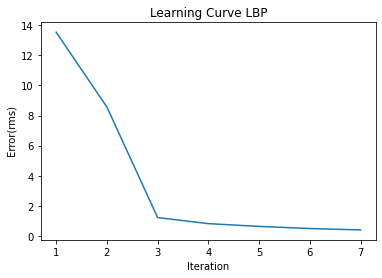

In [5]:
# estimate regularization term
# computed reverse index to be added here (2nd part)
# implement loopy belief propagation

#loppybelief algorithm
def loopybelief(key_fix, key_mov, lamda = 1.50, no_cand= 256):#
    with torch.no_grad():
        print("key_fix size:", key_fix.shape)
        print("key_mov",key_mov.shape)
        sd=(key_fix.unsqueeze(1) - key_mov.unsqueeze(0)).pow(2).sum(2)# pairwise squared dist between keypoints fixed and moving
        _,idx = torch.topk(sd.squeeze(), no_cand, dim = 1, largest= False)#generating index of candidates
        #gathering 256 candidates for registration
        candidates = -key_fix.unsqueeze(1) + torch.gather(key_mov.unsqueeze(1).repeat(1,no_cand,1),0,idx.unsqueeze(2).repeat(1,1,3))
        edge,rev_idx = knngraph(key_fix)
        n = kpts_fixed.squeeze().size(0)
        n_edge = edge.size(0)
        message = torch.zeros(n_edge, no_cand)# #edgex256
        candidate1 = candidates[edge[:,0],:,:]
        candidate2 = candidates[edge[:,1],:,:]
        #initialising temp_message
        temp_message = torch.zeros(n_edge, no_cand)
        #iterating messages through the graph from leaf -> root
        error_data = []

        for i in range(7):
            datacost = torch.gather(temp_message,0,edge[:,0].reshape(-1,1).repeat(1,no_cand))#D_p = 0 in this case
            rev_message = torch.gather(message,0,rev_idx.view(-1,1))
            rev_message = rev_message.repeat(1,no_cand)
            datacost -= rev_message
            for j in range(int(math.ceil(n_edge/512))):
                m = min((j+1)*512, n_edge)
                message[j*512:m] = reg_model(datacost[j*512:m],candidate1[j*512:m],candidate2[j*512:m],lamda)
            temp_message = torch.zeros(n,no_cand)
            temp_message.scatter_add_(0,edge[:,1].reshape(-1,1).repeat(1,no_cand),message)
            print('temp message size',temp_message.shape)
            p = torch.softmax(-50*(temp_message).reshape(n,no_cand).float(),1)
            disp_eval =torch.sum(p.unsqueeze(2)*candidates,1).unsqueeze(0)
            error = reg_error(disp_eval.squeeze(),gt_displacements)
            print('iter:',i,'error:',error)
            error_temp = error.tolist()
            error_data.append(error_temp)
        print(error_data)
        m_s_p = temp_message.reshape(n,no_cand)
        marg = 10*m_s_p.float()
        disp_eval = torch.sum(torch.softmax(-5*marg,1).unsqueeze(2)*candidates,1).unsqueeze(0)
        error_  = np.array(error_data)
        x= np.linspace(1,7,7)
        plt.plot(x,error_data)
        plt.xlabel("Iteration")
        plt.ylabel(" Error(rms) ")
        plt.title('Learning Curve LBP')
        plt.savefig('Learning curve LBP.png')
        plt.show()
    return disp_eval


if __name__ == "__main__":
    loopybelief(kpts_fixed,kpts_moving)






        
 

In [6]:
# Load img and mask

img = torch.from_numpy(nib.load('case_001_insp.nii').get_fdata()).float().flip(2)
mask = torch.from_numpy(nib.load('case_001_insp_mask.nii').get_fdata()).flip(2)

print('Image:',img.shape,'; Mask:',mask.shape)

Image: torch.Size([192, 192, 208]) ; Mask: torch.Size([192, 192, 208])
